https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2


Some finetuning insights for BERT (that can probably be extended to other transformer based architectures)  
https://arxiv.org/pdf/1905.05583.pdf

Seems like RoBERTa has the same model architecture as BERT but trained more optimally so will be trying that out.

In [0]:
%%capture
#Installs
!pip install transformers
!pip install fast-bert
!pip install fastai

In [0]:
from google.colab import drive
import pandas as pd
import numpy as np
import fastai
from fastai.text import * 
from fastai.basics import *
from fastai.callbacks import * 
from fastai.callbacks.mem import PeakMemMetric
from transformers import RobertaForMaskedLM, RobertaTokenizer, RobertaConfig
from transformers import XLNetLMHeadModel, XLNetTokenizer, XLNetConfig
from transformers import AdamW
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from torch.nn import CrossEntropyLoss
from fast_bert.modeling import RobertaForMultiLabelSequenceClassification, XLNetForMultiLabelSequenceClassification, BertForMultiLabelSequenceClassification
from sklearn.metrics import accuracy_score,precision_recall_fscore_support, f1_score, classification_report


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!nvidia-smi

Classifier batch sizes that fit in cuda mem:  
roberta - 56  
xlnet - 45 barely fits (can train with unfrozen weights for 1 epoch) so using 


In [0]:
#@title Magic Panel
is_overall = True #@param {type:"boolean"}
m_type = "roberta" #@param ["roberta", "xlnet"] 
model_names = {"bert":"bert-base-cased","roberta":"distilroberta-base","xlnet":"xlnet-base-cased"}
seed = 1 #@param {type:"integer"}
pretrained_model_name = model_names[m_type]
lm_bs = 16 #@param {type:"slider", min:0, max:1000, step:1}
cl_bs = 128 #@param {type:"slider", min:0, max:1000, step:1}
wd = 0.001 #@param {type:"slider", min:0, max:1, step:0.0001}
mlm_probability = 0.15 #@param {type:"slider", min:0, max:1, step:0.01}


In [0]:
labeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/labeled_cleaned.csv")
unlabeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/unlabeled_cleaned.csv")

categories = ['emotional_disclosure','information_disclosure','general_support','info_support','emo_support']
overall_categories = ['support','disclosive']
path = Path("/content/drive/My Drive/affconsharedtask/")


In [0]:


MODEL_CLASSES = {
    'xlnet': (XLNetLMHeadModel, XLNetForMultiLabelSequenceClassification, XLNetTokenizer, XLNetConfig),
    'roberta': (RobertaForMaskedLM, RobertaForMultiLabelSequenceClassification, RobertaTokenizer, RobertaConfig),
}
    


lm_class, model_class, tokenizer_class, config_class = MODEL_CLASSES[m_type]


In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]
        
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = m_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums)
        nums[nums==-1] = self.tokenizer.mask_token_id
        nums = nums.tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)


In [0]:
def mask_tokens(inputs, tokenizer = transformer_tokenizer):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original. """
    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -1  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long, device='cuda')
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels


In [0]:

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [0]:
pad_first = bool(m_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id


databunch = (TextList.from_df(labeled_comments, path, cols='full_text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols=overall_categories if is_overall else categories)
             .databunch(bs=cl_bs, pad_first=pad_first, pad_idx=pad_idx))

lm_databunch = (TextList.from_df(unlabeled_comments, path, cols='full_text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_empty()
             .databunch(bs=lm_bs, pad_first=pad_first, pad_idx=pad_idx))



In [0]:
databunch.show_batch()

In [0]:
#update batch size
lm_databunch.batch_size=lm_bs
databunch.batch_size=cl_bs

In [0]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits
    
    def reset(self): pass

####Debug block

In [0]:
temp=lm_databunch.one_batch(cpu=False)[0]
tempx,tempy=mask_tokens(temp)
transformer_lm_temp = lm_class.from_pretrained(pretrained_model_name)
transformer_lm_temp.to('cuda')
temp_out=transformer_lm_temp.forward(tempx,masked_lm_labels=tempy)
#del transformer_lm_temp
#torch.cuda.empty_cache()
#!nvidia-smi

In [0]:
config = config_class.from_pretrained(pretrained_model_name)

In [0]:
loss_fct = CrossEntropyLoss(ignore_index=-1)
#masked_lm_loss = loss_fct(, )
tempy.view(-1).shape

torch.Size([8192])

### Training 

In [0]:
del transformer_model
del custom_transformer_model
#del databunch
del lm_databunch
#del transformer_lm
#del custom_transformer_lm
del config
gc.collect()
learner.destroy()
torch.cuda.empty_cache()


this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
!nvidia-smi

Tue Jan  7 02:06:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |  15181MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(overall_categories) if is_overall else len(categories)

transformer_model = model_class.from_pretrained(path/'roberta-lm', config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)


In [0]:
f_beta = MultiLabelFbeta(beta=1,thresh=0.5)

#loss here defaults to Binary Cross Entropy on logits as we supply multi-labeled data
learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input, correct_bias=False, weight_decay=wd), 
                  metrics=[accuracy,accuracy_thresh,f_beta],
                  callback_fns=[PeakMemMetric]).to_fp16()



In [0]:
xln_layer_list=[]
'''
xln_layer_list=[learner.model.transformer.transformer.word_embedding]
xln_layer_list.extend([i for i in learner.model.transformer.transformer.layer])
xln_layer_list.append(learner.model.transformer.sequence_summary)
'''
rb_layer_list = []
rb_layer_list=[learner.model.transformer.roberta.embeddings]
rb_layer_list.extend([i for i in learner.model.transformer.roberta.encoder.layer])
rb_layer_list.append(learner.model.transformer.roberta.pooler)
b_layer_list=[]
'''
b_layer_list=[learner.model.transformer.bert.embeddings]
b_layer_list.extend([i for i in learner.model.transformer.bert.encoder.layer])
b_layer_list.append(learner.model.transformer.bert.pooler)
'''
layer_lists = {"roberta":rb_layer_list,"bert":b_layer_list,"xlnet":xln_layer_list}
layer_list = layer_lists[m_type]

In [0]:
learner.split(layer_list)
num_groups = len(learner.layer_groups)


####Gradual Unfreezing

Seems to have no real effect on the metrics so will just train directly

In [0]:
learner.freeze() #doesnt freeze classifier

AssertionError: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 1.10E-03


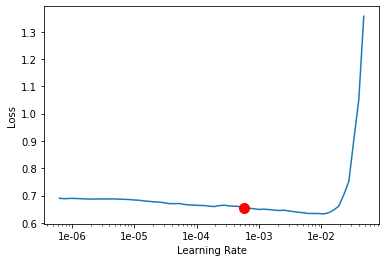

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=1e-3,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.527467,0.517298,0.400855,0.734837,0.667317,00:07


In [0]:
learner.save("xlnet_zeroth")

In [0]:
learner.load("xlnet_zeroth")

In [0]:
learner.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


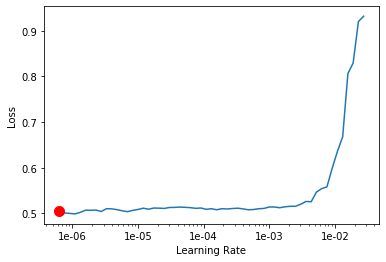

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=5e-5,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.514411,0.514051,0.401633,0.735614,0.651996,00:07


In [0]:
learner.save("xlnet_first")

In [0]:
learner.load("roberta_first")

In [0]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 2.75E-05


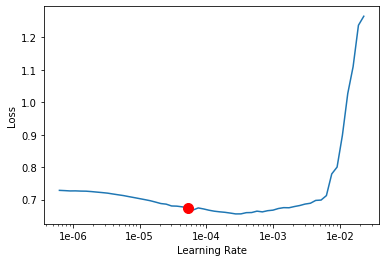

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=min_grad_lr,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.523387,0.503644,0.405521,0.743002,0.661893,00:17


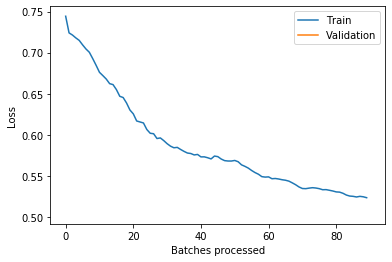

In [0]:
learner.recorder.plot_losses()

In [0]:
learner.save("roberta_sec")

In [0]:
learner.load("roberta_sec")

AttributeError: ignored

In [0]:
learner.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-07


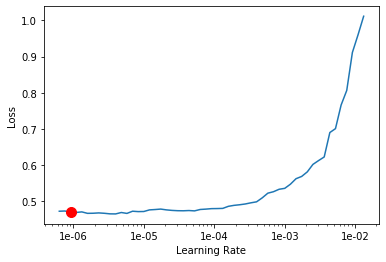

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(1,max_lr=1e-6,moms=(0.8,0.9))

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,time
0,0.468325,0.506622,0.396967,0.746112,0.671694,00:17


In [0]:
learner.save("xlnet_third_with_wd_smbs")

In [0]:
learner.metrics=[accuracy,accuracy_thresh] #throws error when loading so remove f_beta when loading then add it back
learner.load("xlnet_third_with_wd_smbs")
learner.metrics=[accuracy,accuracy_thresh,f_beta]

#### Train after unfreeze

In [0]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 6.31E-06


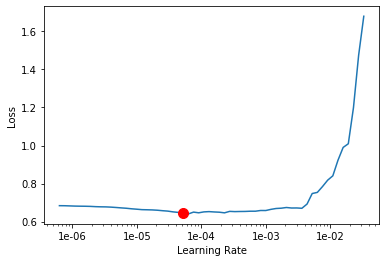

In [0]:
learner.lr_find()
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

In [0]:
learner.fit_one_cycle(5,max_lr=1e-6,moms=(0.8,0.9),callbacks=[SaveModelCallback(learner,every="improvement",monitor="valid_loss",name="distilroberta_clas_withlm")])

epoch,train_loss,valid_loss,accuracy,accuracy_thresh,multi_label_fbeta,cpu used,peak,gpu used,peak,time
0,0.501158,0.510108,0.396967,0.741058,0.671273,0,0,732,6194,00:18
1,0.495586,0.505059,0.393079,0.748056,0.670061,0,0,0,6698,00:17
2,0.485882,0.504533,0.392302,0.746501,0.675299,0,0,0,6698,00:18
3,0.480734,0.504653,0.393079,0.746890,0.676280,0,0,0,6698,00:19
4,0.476173,0.504646,0.393857,0.748445,0.677949,0,0,0,6698,00:18


Better model found at epoch 0 with valid_loss value: 0.5101079940795898.
Better model found at epoch 1 with valid_loss value: 0.5050588250160217.
Better model found at epoch 2 with valid_loss value: 0.5045326948165894.


In [0]:
learner.recorder.plot_losses()

NameError: ignored

In [0]:
learner.save("xlnet-no-lm-temp")

In [0]:
learner.metrics=[accuracy,accuracy_thresh]
learner.load("distilroberta_clas_withlm")
learner.metrics=[accuracy,accuracy_thresh,f_beta]

In [0]:
learner.validate()

[0.5045327, tensor(0.3923), tensor(0.7465), tensor(0.6753, device='cuda:0')]

In [0]:
learner.save("xlnet_clas_no_lm")

In [0]:
del inp,out
gc.collect()
torch.cuda.empty_cache()

In [0]:
!nvidia-smi

Tue Jan  7 02:05:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |  15181MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:

torch.cuda.empty_cache()
inp,out=databunch.one_batch(cpu=False)
custom_transformer_model.to('cuda')



In [0]:
learner.get_preds(),fastai.basic_train._loss_func2activ(learner.loss_func)(custom_transformer_model.forward(inp))

####Get results

In [0]:
#@title panel
#default activation function is derived from the loss when getting preds
preds,t_labels = learner.get_preds()
preds,t_labels = preds.numpy(),t_labels.numpy()
thresh = 0.5 #@param
preds[preds >= thresh]=1
preds[preds < thresh]=0
print(classification_report(t_labels,preds,target_names=overall_categories,digits=5))
print(accuracy_score(t_labels,preds))

              precision    recall  f1-score   support

     support    0.64873   0.61194   0.62980       335
  disclosive    0.69253   0.70178   0.69713       674

   micro avg    0.67868   0.67195   0.67530      1009
   macro avg    0.67063   0.65686   0.66346      1009
weighted avg    0.67799   0.67195   0.67477      1009
 samples avg    0.46462   0.46501   0.45671      1009

0.557542768273717


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


|                             | Accuracy            | Precision          | Recall             | F1 Score           |
|-----------------------------|--------------------|--------------------|--------------------|--------------------|
| RoBERTa without lm finetune | 0.5707620528771384 | 0.684931506849315  | 0.6937561942517344 | 0.6893156080748399 |
| XLNet without lm finetune   | 0.5590979782270606 | 0.6691244239631337 | 0.7195242814667988 | 0.6934097421203438 |


##### lm 3:
###### best valid loss was kept:
>lr:2e-5,wd:0.001 
(0.7167042889390519, 0.6293359762140733, 0.670184696569921, None)
0.5754276827371695

>lr:1e-5,wd:0.001 
(0.678963110667996, 0.6749256689791873, 0.6769383697813122, None)
0.562208398133748

>lr:1e-4,wd:0.001  
(0.6697626418988648, 0.643211100099108, 0.6562184024266936, None)
0.5427682737169518

>lr:5e-5,wd:0.001  
>(0.6740597878495661, 0.6927651139742319, 0.6832844574780058, None)
>0.5598755832037325

>lr:1e-3,wd:0.001  
>(0.5241057542768274, 0.66798810703667, 0.587363834422658, None)
>0.42068429237947125

###### best f1 score was kept:
>lr:2e-5,wd:0.001  
(0.6678798908098271, 0.7274529236868187, 0.6963946869070209, None)
0.5668740279937792

>lr:1e-5,wd:0.01   
(0.6825242718446602, 0.6967294350842418, 0.689553702795488, None)
0.567651632970451

##### lm 6:  
Seems worse overall over the many attempts (not recorded)
lr:7e-5,wd:0.001
(0.698051948051948, 0.6392467789890981, 0.6673564407656492, None)
0.5544323483670296

##### lm 7:  
>lr:2e-5,wd:0.001  
(0.6724303554274735, 0.6937561942517344, 0.6829268292682927, None)
0.5544323483670296

>lr:1e-4,wd:0.001  
(0.6835978835978836, 0.6402378592666006, 0.6612077789150461, None)
0.5443234836702955

>lr:1e-5,wd:0.001  
(0.6734892787524367, 0.6848364717542121, 0.6791154791154792, None)
0.5559875583203733

>lr:9e-6,wd:0.001  
(0.6902564102564103, 0.6669970267591675, 0.6784274193548386, None)
0.5645412130637636

>lr:5e-6,wd:0.001  
(0.6837944664031621, 0.6858275520317145, 0.6848095002474023, None)
0.5637636080870918

>lr:1e-6,wd:0.001 (more epochs than usual)  
(0.6829025844930418, 0.6808721506442021, 0.6818858560794046, None)
0.5668740279937792

>lr:2e-6,wd:0.001
(0.6791120080726539, 0.6669970267591675, 0.673, None)
0.5528771384136858

##### lm 8:  

>lr:5e-5,wd:0.001  
(0.7510489510489511, 0.5322101090188305, 0.622969837587007, None)
0.5497667185069984

>lr:2e-5,wd:0.001  
(0.6762452107279694, 0.6997026759167493, 0.6877739892839747, None)
0.5552099533437014

>lr:1e-5,wd:0.001  
(0.6759615384615385, 0.6967294350842418, 0.6861883845778428, None)
0.5629860031104199

>lr:9e-6,wd:0.001  
(0.7004264392324094, 0.6511397423191279, 0.6748844375963019, None)
0.5699844479004665

>lr:1e-4,wd:0.001  
(0.7113133940182055, 0.5421209117938554, 0.6152980877390326, None)
0.5427682737169518

>lr:1e-6,wd:0.001  
(0.6923879040667362, 0.6580773042616452, 0.6747967479674797, None)
0.5660964230171073

>lr:5e-6,wd:0.001  
(0.6791907514450867, 0.6987115956392468, 0.6888128969223253, None)
0.5684292379471229

##### lm 9:  
>lr:1e-5,wd:0.001  
(0.6918429003021148, 0.6808721506442021, 0.6863136863136863, None)
0.5754276827371695

>lr:2e-5,wd:0.001  
(0.6914778856526429, 0.6352824578790882, 0.6621900826446281, None)
0.5544323483670296

>lr:9e-6,wd:0.001  
(0.6778523489932886, 0.7006937561942518, 0.689083820662768, None)
0.562208398133748

>lr:5e-6,wd:0.001  
(0.7067099567099567, 0.647175421209118, 0.6756337299534403, None)
0.5746500777604977

>lr:2e-6,wd:0.001  
(0.6854838709677419, 0.6739345887016849, 0.6796601699150424, None)
0.5637636080870918

>lr:1e-6,wd:0.001  
(0.6786786786786787, 0.6719524281466799, 0.6752988047808764, None)
0.557542768273717